# Prepare fGWAS input matrix - tss_cell_type_exp.txt.gz

#### input

- a file called `tss_cell_type_exp.txt.gz` (tab separated and gzipped) with one row per gene and:
  - 1st column: chromosome number
  - 2nd column: chromosome position
  - next columns, one for each cell type: mean expression of gene in cell type
  - last column: overall mean expression for the gene
  - sorted ascending by first two columns
  - no header

- a file called `celltype.txt`
  - list of cell type names
  - same order as in `tss_cell_type_exp.txt.gz`

- GWAS summary statistics:
  - full summary statistics including SNP position, beta value, standard error
  - list of files from open targets available on farm: `/warehouse/cellgeni/otar-gwas-ss/gwas/`
  - other summary stats can e.g. be downloaded from EBI GWAS atlas in harmonised format

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import os
import sys
import scipy
import anndata


def grouped_obs_mean(adata, group_key, layer=None, gene_symbols=None):
    if layer is not None:
        getX = lambda x: x.layers[layer]
    else:
        getX = lambda x: x.X
    if gene_symbols is not None:
        new_idx = adata.var[idx]
    else:
        new_idx = adata.var_names

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

### Load adata

In [11]:
path2data = '/nfs/team292/lg18/endometriosis/clustered_objects/'
adata = sc.read(path2data + 'cells.h5ad')
adata.X.shape

(390867, 17736)

In [12]:
annot_all = adata.obs['Mareckova_celltype'].to_dict()
annot = dict(annot_all)


annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/cells_endometrium_epithelial_CLEAN.csv',index_col=0)
annot_df.at[annot_df['Mareckova_epi_celltype'] == 'Hormones', 'Mareckova_epi_celltype'] = 'eHormones'
annot_df.at[annot_df['Mareckova_epi_celltype'] == 'Hormones_secretory', 'Mareckova_epi_celltype'] = 'eHormones'
annot_df.head()
annot1 = annot_df['Mareckova_epi_celltype'].to_dict()
annot.update(annot1)


annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/cells_endometrium_mesenchymal_CLEAN.csv',index_col=0)
annot_df.at[annot_df['Mareckova_mesen_celltype'] == 'Hormones', 'Mareckova_mesen_celltype'] = 'sHormones'
annot_df.head()
annot2 = annot_df['Mareckova_mesen_celltype'].to_dict()
annot.update(annot2)

annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/cells_endometrium_endothelial.csv',index_col=0)
annot_df.head()
annot2 = annot_df['Mareckova_endo_celltype'].to_dict()
annot.update(annot2)

annot_df = pd.read_csv('/nfs/team292/lg18/endometriosis/annotations/cells_endometrium_immune.csv',index_col=0)
annot_df.head()
annot2 = annot_df['immune_subcluster_labels'].to_dict()
annot.update(annot2)


adata.obs['celltype'] = adata.obs_names.map(annot)
print(adata.obs['celltype'].value_counts())

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (15,19,21,22,23,24,25,39,40,41,46,47,60,61,63,64,65) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (13,15,17,18,19,21,22,23,24,25,41,42,46,55,58) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


eStromal           55612
dStromal_mid       43790
Mesen_dStromal     22381
dStromal_early     16804
Venous             15494
                   ...  
cDC1                 188
dHormones            172
Plasma_B_Cell         89
Red_Blood_Cell        43
Epi_cervix_KRT5       23
Name: celltype, Length: 74, dtype: int64


#### Remove lowQC and doublets

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'celltype' as categorical


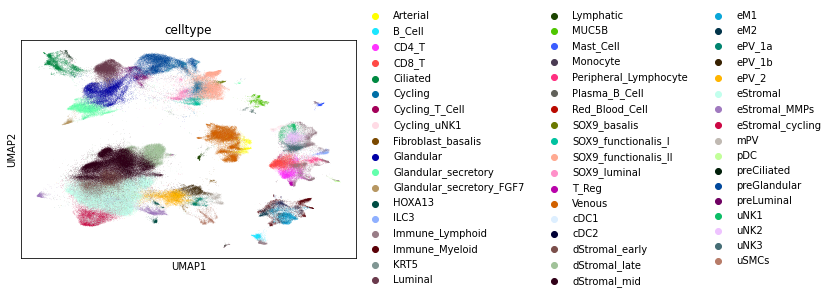

In [13]:
set(adata.obs['Mareckova_celltype'])
adata = adata[[ i not in ['Doublet', 'LowQC'] for i in adata.obs['Mareckova_celltype'] ]]
adata = adata[[ i not in ['Doublet', 'LowQC', 'Other', 'eHormones', 'sHormones', 'dHormones'] for i in adata.obs['celltype'] ]]
adata = adata[[ 'Epi_' not in i for i in adata.obs['celltype'] ]]
adata = adata[[ 'Mesen_' not in i for i in adata.obs['celltype'] ]]
adata = adata[[ 'Immune' not in i for i in adata.obs['celltype'] ]]
sc.pl.umap(adata, color=['celltype'])

## Load chromosome information

In [17]:
fgwas_biomart = pd.read_csv('mart_export_buildGRCh38.txt', sep = '\t')
fgwas_biomart = fgwas_biomart.drop_duplicates(subset='Gene name', keep="first")
fgwas_biomart = fgwas_biomart.set_index('Gene name')

common_genes = [i for i in fgwas_biomart.index.tolist() if i in adata.var_names.tolist()] # adata is your object 
len(common_genes)

fgwas_biomart = fgwas_biomart.loc[common_genes]
adata = adata[:, common_genes]

adata.var['ENSEMBLID'] = adata.var_names.map(fgwas_biomart['Gene stable ID'].to_dict())
adata.var = adata.var.set_index('ENSEMBLID')

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Trying to set attribute `.var` of view, copying.


### Construct matrix

In [18]:
fgwas_df = grouped_obs_mean(adata, group_key = 'celltype') # fgwas_annotations is the cell type anntoations
fgwas_df['Chromosome'] = fgwas_df.index.map(pd.Series(fgwas_biomart['Chromosome/scaffold name'].values, index=fgwas_biomart['Gene stable ID']).to_dict())
fgwas_df['TSS'] = fgwas_df.index.map(pd.Series(fgwas_biomart['Transcription start site (TSS)'].values, index=fgwas_biomart['Gene stable ID']).to_dict())
adata.var['MeanExpression'] = np.ravel(adata.X.mean(axis=0, dtype=np.float64))
fgwas_df['MeanExpression'] = fgwas_df.index.map(adata.var['MeanExpression'].to_dict())

In [19]:
fgwas_df.columns

Index(['Arterial', 'B_Cell', 'CD4_T', 'CD8_T', 'Ciliated', 'Cycling',
       'Cycling_T_Cell', 'Cycling_uNK1', 'Fibroblast_basalis', 'Glandular',
       'Glandular_secretory', 'Glandular_secretory_FGF7', 'HOXA13', 'ILC3',
       'Immune_Lymphoid', 'Immune_Myeloid', 'KRT5', 'Luminal', 'Lymphatic',
       'MUC5B', 'Mast_Cell', 'Monocyte', 'Peripheral_Lymphocyte',
       'Plasma_B_Cell', 'Red_Blood_Cell', 'SOX9_basalis',
       'SOX9_functionalis_I', 'SOX9_functionalis_II', 'SOX9_luminal', 'T_Reg',
       'Venous', 'cDC1', 'cDC2', 'dStromal_early', 'dStromal_late',
       'dStromal_mid', 'eM1', 'eM2', 'ePV_1a', 'ePV_1b', 'ePV_2', 'eStromal',
       'eStromal_MMPs', 'eStromal_cycling', 'mPV', 'pDC', 'preCiliated',
       'preGlandular', 'preLuminal', 'uNK1', 'uNK2', 'uNK3', 'uSMCs',
       'Chromosome', 'TSS', 'MeanExpression'],
      dtype='object')

In [20]:
fgwas_df = fgwas_df[['Chromosome', 'TSS', 
       'Arterial', 'B_Cell', 'CD4_T', 'CD8_T', 'Ciliated', 'Cycling',
       'Cycling_T_Cell', 'Cycling_uNK1', 'Fibroblast_basalis', 'Glandular',
       'Glandular_secretory', 'Glandular_secretory_FGF7', 'HOXA13', 'ILC3',
       'Immune_Lymphoid', 'Immune_Myeloid', 'KRT5', 'Luminal', 'Lymphatic',
       'MUC5B', 'Mast_Cell', 'Monocyte', 'Peripheral_Lymphocyte',
       'Plasma_B_Cell', 'Red_Blood_Cell', 'SOX9_basalis',
       'SOX9_functionalis_I', 'SOX9_functionalis_II', 'SOX9_luminal', 'T_Reg',
       'Venous', 'cDC1', 'cDC2', 'dStromal_early', 'dStromal_late',
       'dStromal_mid', 'eM1', 'eM2', 'ePV_1a', 'ePV_1b', 'ePV_2', 'eStromal',
       'eStromal_MMPs', 'eStromal_cycling', 'mPV', 'pDC', 'preCiliated',
       'preGlandular', 'preLuminal', 'uNK1', 'uNK2', 'uNK3', 'uSMCs',           
       'MeanExpression']] # this is just to reorder the columns 

In [21]:
fgwas_df_sorted = fgwas_df.sort_values(['Chromosome', 'TSS'],
              ascending = [True, True])
fgwas_df_sorted['Chromosome'] = fgwas_df_sorted['Chromosome'].astype(str)
fgwas_df_sorted = fgwas_df_sorted[fgwas_df_sorted['Chromosome'].isin(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', 
                    '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22'])]
fgwas_df_sorted['Chromosome'] = fgwas_df_sorted['Chromosome'].astype(int)

In [22]:
fgwas_df_sorted.to_csv('/nfs/team292/lg18/endometriosis/fGWAs/tss_cell_type_exp.txt', sep = '\t', 
                      header = False, index = False)

### Write celltype.txt

In [23]:
celltypes = ['Arterial', 'B_Cell', 'CD4_T', 'CD8_T', 'Ciliated', 'Cycling',
       'Cycling_T_Cell', 'Cycling_uNK1', 'Fibroblast_basalis', 'Glandular',
       'Glandular_secretory', 'Glandular_secretory_FGF7', 'HOXA13', 'ILC3',
       'Immune_Lymphoid', 'Immune_Myeloid', 'KRT5', 'Luminal', 'Lymphatic',
       'MUC5B', 'Mast_Cell', 'Monocyte', 'Peripheral_Lymphocyte',
       'Plasma_B_Cell', 'Red_Blood_Cell', 'SOX9_basalis',
       'SOX9_functionalis_I', 'SOX9_functionalis_II', 'SOX9_luminal', 'T_Reg',
       'Venous', 'cDC1', 'cDC2', 'dStromal_early', 'dStromal_late',
       'dStromal_mid', 'eM1', 'eM2', 'ePV_1a', 'ePV_1b', 'ePV_2', 'eStromal',
       'eStromal_MMPs', 'eStromal_cycling', 'mPV', 'pDC', 'preCiliated',
       'preGlandular', 'preLuminal', 'uNK1', 'uNK2', 'uNK3', 'uSMCs']
df_celltypes = pd.DataFrame(celltypes, columns=['celltype'])
df_celltypes.to_csv('/nfs/team292/lg18/endometriosis/fGWAs/celltype.txt', sep = '\t', 
                      header = False, index = False)